# Data Mining Project - Sustainability Around The World 
### Aradhya Mathur and Ozlem Gunes

## Time Series Analysis 

In [1]:
# Import libs
import pandas as pd
import numpy as np
import os, fnmatch
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.metrics as mt
import seaborn as sns
from pmdarima.arima import auto_arima
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

### Read Data

In [4]:
data_path = "./master.csv"

In [5]:
data = pd.read_csv(data_path)

In [6]:
data[0:5]

,year,iso,country,region,EPI,AIR,H2O,BDH,WRS
0,2022,AFG,Afghanistan,Southern Asia,43.6,15.5,28.1,30.7,0.0
1,2022,ALB,Albania,Eastern Europe,47.1,37.5,54.1,63.9,1.9
2,2022,DZA,Algeria,Greater Middle East,29.6,39.4,53.3,22.7,33.1
3,2022,AGO,Angola,Sub-Saharan Africa,30.5,23.1,12.8,30.1,0.0
4,2022,ATG,Antigua and Barbuda,Latin America & Caribbean,52.4,56.5,50.1,54.2,15.7


### Preprocess and Analysis

#### Get countries with sufficient data points

In [7]:
selected_countries = data[data['year'].isin([2018,2020,2022])]['country'].unique()

In [8]:
selected_countries

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Dem. Rep. Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
     

In [9]:
data = data[data['country'].isin(selected_countries)]

In [10]:
data

,year,iso,country,region,EPI,AIR,H2O,BDH,WRS
0,2022,AFG,Afghanistan,Southern Asia,43.60,15.50,28.10,30.70,0.00
1,2022,ALB,Albania,Eastern Europe,47.10,37.50,54.10,63.90,1.90
2,2022,DZA,Algeria,Greater Middle East,29.60,39.40,53.30,22.70,33.10
3,2022,AGO,Angola,Sub-Saharan Africa,30.50,23.10,12.80,30.10,0.00
4,2022,ATG,Antigua and Barbuda,Latin America & Caribbean,52.40,56.50,50.10,54.20,15.70
...,...,...,...,...,...,...,...,...,...
1170,2010,UZB,Uzbekistan,Former Soviet States,42.27,65.07,87.41,21.75,21.53
1171,2010,VEN,Venezuela,Latin America & Caribbean,62.90,97.37,83.52,78.19,56.12
1172,2010,VNM,Viet Nam,Asia-Pacific,59.00,41.47,73.46,41.28,78.05
1173,2010,ZMB,Zambia,Sub-Saharan Africa,47.00,36.76,36.86,100.00,70.28


In [11]:
data_count = data.groupby(['country'])['year'].count().reset_index(name='counts').sort_values('counts', ascending=False)

In [12]:
selected_countries = data_count[data_count['counts']>6]['country'].unique()

In [13]:
data = data[data['country'].isin(selected_countries)]

In [14]:
data[1:5]

,year,iso,country,region,EPI,AIR,H2O,BDH,WRS
2,2022,DZA,Algeria,Greater Middle East,29.6,39.4,53.3,22.7,33.1
3,2022,AGO,Angola,Sub-Saharan Africa,30.5,23.1,12.8,30.1,0.0
5,2022,ARG,Argentina,Latin America & Caribbean,41.1,52.0,64.8,42.4,5.9
6,2022,ARM,Armenia,Former Soviet States,48.3,32.1,57.3,73.3,4.5


In [15]:
data = data.reset_index(drop=True)

In [16]:
data.isnull().sum(axis = 0)

year       0
iso        0
country    0
region     0
EPI        0
AIR        0
H2O        0
BDH        0
WRS        0
dtype: int64

### Handle Null Values

In [17]:
# data = data.sort_values(['country', 'year'])
# data['index'] = data.groupby(['country']).cumcount()

In [18]:
idx = data[['year']].drop_duplicates().sort_values('year', axis=0).reset_index(drop=True)
idx['idx'] = idx.index
# idx['idx'] = idx['idx'].astype(str)

In [19]:
idx

,year,idx
0,2010,0
1,2012,1
2,2014,2
3,2016,3
4,2018,4
5,2020,5
6,2022,6


In [20]:
data = data.merge(idx, on='year')

### Models - Predict 2020

#### Data Sets

In [21]:
data_train = data[data['year'] < 2020]
data_test = data[data['year'].isin([2020])]

In [22]:
data_train.sort_values(['country', 'year'])[1:5]

,year,iso,country,region,EPI,AIR,H2O,BDH,WRS,idx
615,2012,ALB,Albania,Eastern Europe,65.85,100.00,72.28,61.72,23.19,1
492,2014,ALB,Albania,Eastern Europe,54.73,68.24,55.91,63.19,3.36,2
369,2016,ALB,Albania,Eastern Europe,29.61,37.41,48.46,26.07,2.70,3
246,2018,ALB,Albania,Eastern Europe,38.80,37.10,51.50,57.10,2.70,4


In [23]:
data_test[1:5]

,year,iso,country,region,EPI,AIR,H2O,BDH,WRS,idx
124,2020,DZA,Algeria,Greater Middle East,44.8,45.3,53.2,39.0,33.1,5
125,2020,AGO,Angola,Sub-Saharan Africa,29.7,26.8,12.8,39.3,0.0,5
126,2020,ARG,Argentina,Latin America & Caribbean,52.2,56.9,64.7,49.1,5.9,5
127,2020,ARM,Armenia,Former Soviet States,52.3,36.3,57.2,79.2,8.8,5


### Simple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     67.46
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.28e-15
Time:                        03:18:21   Log-Likelihood:                -2506.3
No. Observations:                 615   AIC:                             5017.
Df Residuals:                     613   BIC:                             5025.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.0999      0.996     59.313      0.0

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

<AxesSubplot:xlabel='idx', ylabel='fitted'>

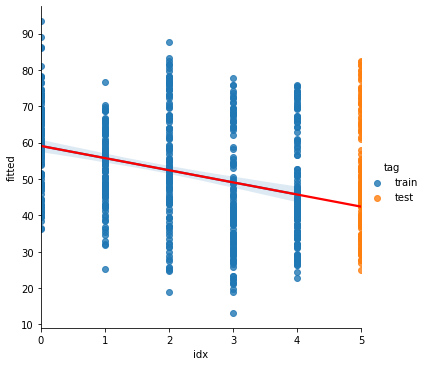

In [24]:
# Train-predict and plot for all countries
x_train = data_train[['idx']]
y_train = data_train['EPI']

x_test = data_test[['idx']]
y_test = data_test['EPI']
 
# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=True)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

In [25]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [26]:
mt.mean_squared_error(y_test, predictions)

320.56405438271065

#### Sample Country

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     2.256
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.230
Time:                        03:18:42   Log-Likelihood:                -13.755
No. Observations:                   5   AIC:                             31.51
Df Residuals:                       3   BIC:                             30.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.2340      3.789     20.650      0.0

<AxesSubplot:xlabel='idx', ylabel='fitted'>

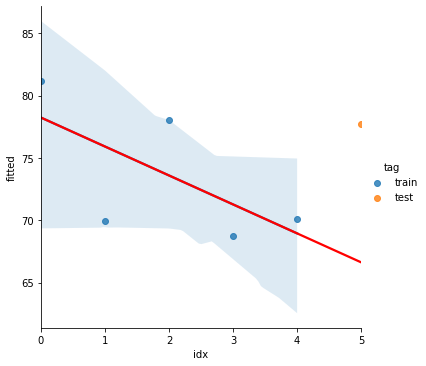

In [27]:
# Train-predict and plot for sample country Norway
country = 'Norway'
x_train = data_train[data_train['country'] == country][['idx']]
y_train = data_train[data_train['country'] == country]['EPI']

x_test = data_test[data_test['country'] == country][['idx']]
y_test = data_test[data_test['country'] == country]['EPI']
 
# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train[data_train['country'] == country]
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test[data_test['country'] == country]
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=True)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

In [28]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [29]:
mt.mean_squared_error(y_test, predictions)

122.78856100000007

### Multiple Linear Regression

<AxesSubplot:xlabel='AIR', ylabel='EPI'>

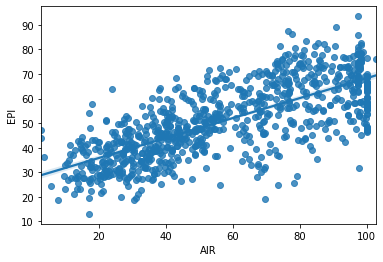

In [30]:
sns.regplot(x='AIR', y='EPI', data=data)

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     668.4
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          1.62e-244
Time:                        03:19:03   Log-Likelihood:                -1963.4
No. Observations:                 615   AIC:                             3939.
Df Residuals:                     609   BIC:                             3965.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7819      0.956     18.610      0.0

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

<AxesSubplot:xlabel='idx', ylabel='fitted'>

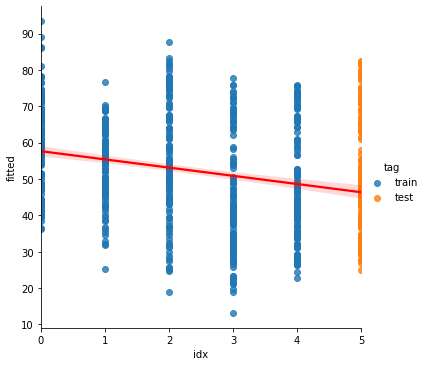

In [31]:
x_train = data_train[['idx', 'AIR', 'H2O', 'BDH', 'WRS']]
y_train = data_train['EPI']

x_test = data_test[['idx', 'AIR', 'H2O', 'BDH', 'WRS']]
y_test = data_test['EPI']

# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + \
                            data_plot_train['AIR'] * p.AIR + \
                            data_plot_train['H2O'] * p.H2O + \
                            data_plot_train['BDH'] * p.BDH + \
                            data_plot_train['WRS'] * p.WRS + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + \
                            data_plot_test['AIR'] * p.AIR + \
                            data_plot_test['H2O'] * p.H2O + \
                            data_plot_test['BDH'] * p.BDH + \
                            data_plot_test['WRS'] * p.WRS + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=False)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


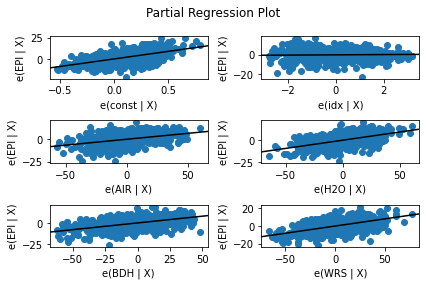

In [32]:
fig = sm.graphics.plot_partregress_grid(model)
fig.tight_layout(pad=1.0)

In [33]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [34]:
mt.mean_squared_error(y_test, predictions)

20.794376334029756

#### Sample Country

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1766: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-package

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                nan
Time:                        03:19:23   Log-Likelihood:                 144.69
No. Observations:                   5   AIC:                            -279.4
Df Residuals:                       0   BIC:                            -281.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034        inf          0        n

<AxesSubplot:xlabel='idx', ylabel='fitted'>

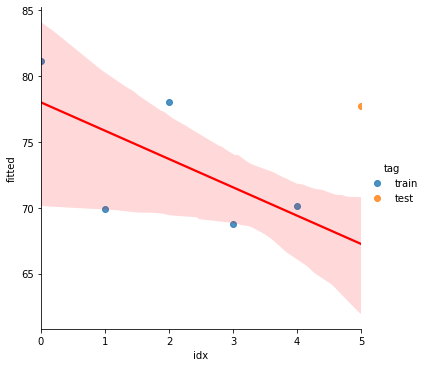

In [35]:
# Train-predict and plot for sample country Norway
x_train = data_train[data_train['country'] == country][['idx', 'AIR', 'H2O', 'BDH', 'WRS']]
y_train = data_train[data_train['country'] == country]['EPI']

x_test = data_test[data_test['country'] == country][['idx', 'AIR', 'H2O', 'BDH', 'WRS']]
y_test = data_test[data_test['country'] == country]['EPI']
 
# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train[data_train['country'] == country]
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + \
                            data_plot_train['AIR'] * p.AIR + \
                            data_plot_train['H2O'] * p.H2O + \
                            data_plot_train['BDH'] * p.BDH + \
                            data_plot_train['WRS'] * p.WRS + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test[data_test['country'] == country]
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + \
                            data_plot_test['AIR'] * p.AIR + \
                            data_plot_test['H2O'] * p.H2O + \
                            data_plot_test['BDH'] * p.BDH + \
                            data_plot_test['WRS'] * p.WRS + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=False)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

In [36]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [37]:
mt.mean_squared_error(y_test, predictions)

97.68311940770529

### Models - Predict 2022

#### Data Sets

In [38]:
data_train = data[(data['year'] < 2022)]
data_test = data[data['year'].isin([2022])]

### Simple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     44.67
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.61e-11
Time:                        03:19:40   Log-Likelihood:                -3030.8
No. Observations:                 738   AIC:                             6066.
Df Residuals:                     736   BIC:                             6075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4727      0.961     59.827      0.0

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

<AxesSubplot:xlabel='idx', ylabel='fitted'>

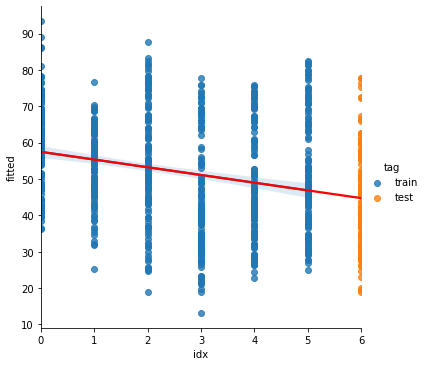

In [39]:
x_train = data_train[['idx']]
y_train = data_train['EPI']

x_test = data_test[['idx']]
y_test = data_test['EPI']
 
# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=True)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

In [40]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [41]:
mt.mean_squared_error(y_test, predictions)

183.67397634532637

#### Sample Country

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                 -0.164
Method:                 Least Squares   F-statistic:                    0.2943
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.616
Time:                        03:20:47   Log-Likelihood:                -17.746
No. Observations:                   6   AIC:                             39.49
Df Residuals:                       4   BIC:                             39.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.1233      4.130     18.433      0.0

<AxesSubplot:xlabel='idx', ylabel='fitted'>

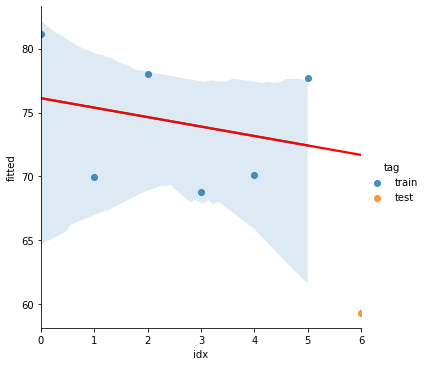

In [42]:
# Train-predict and plot for sample country Norway
x_train = data_train[data_train['country'] == country][['idx']]
y_train = data_train[data_train['country'] == country]['EPI']

x_test = data_test[data_test['country'] == country][['idx']]
y_test = data_test[data_test['country'] == country]['EPI']
 
# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train[data_train['country'] == country]
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test[data_test['country'] == country]
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=True)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

In [43]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [44]:
mt.mean_squared_error(y_test, predictions)

153.3469444444439

### Multiple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     895.4
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          5.09e-309
Time:                        03:20:58   Log-Likelihood:                -2328.5
No. Observations:                 738   AIC:                             4669.
Df Residuals:                     732   BIC:                             4697.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.8606      0.824     20.470      0.0

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

<AxesSubplot:xlabel='idx', ylabel='fitted'>

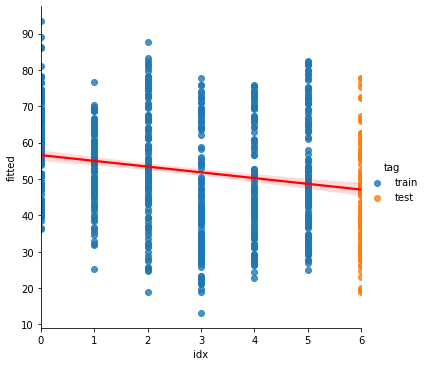

In [45]:
x_train = data_train[['idx','AIR', 'H2O', 'BDH', 'WRS']]
y_train = data_train['EPI']

x_test = data_test[['idx','AIR', 'H2O', 'BDH', 'WRS']]
y_test = data_test['EPI']

# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + \
                            data_plot_train['AIR'] * p.AIR + \
                            data_plot_train['H2O'] * p.H2O + \
                            data_plot_train['BDH'] * p.BDH + \
                            data_plot_train['WRS'] * p.WRS + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + \
                            data_plot_test['AIR'] * p.AIR + \
                            data_plot_test['H2O'] * p.H2O + \
                            data_plot_test['BDH'] * p.BDH + \
                            data_plot_test['WRS'] * p.WRS + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=False)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

In [46]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [47]:
mt.mean_squared_error(y_test, predictions)

77.71281286078752

#### Sample Country

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1766: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-package

                            OLS Regression Results                            
Dep. Variable:                    EPI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                nan
Time:                        03:21:30   Log-Likelihood:                 146.03
No. Observations:                   6   AIC:                            -280.1
Df Residuals:                       0   BIC:                            -281.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1390.5510        inf         -0        n

<AxesSubplot:xlabel='idx', ylabel='fitted'>

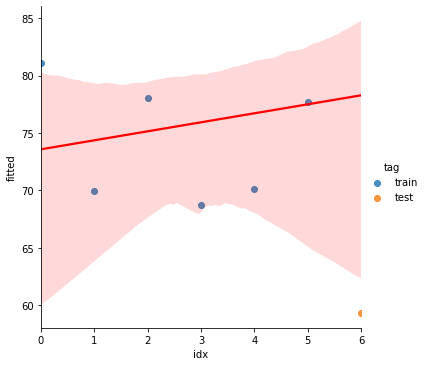

In [48]:
# Train-predict and plot for sample country Norway
x_train = data_train[data_train['country'] == country][['idx', 'AIR', 'H2O', 'BDH', 'WRS']]
y_train = data_train[data_train['country'] == country]['EPI']

x_test = data_test[data_test['country'] == country][['idx', 'AIR', 'H2O', 'BDH', 'WRS']]
y_test = data_test[data_test['country'] == country]['EPI']
 
# with statsmodels
x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(y_train, x_train).fit()
predictions_train = model.predict(x_train) 

print_model = model.summary()
print(print_model)

p = model.params
data_plot_train = data_train[data_train['country'] == country]
data_plot_train['fitted'] = data_plot_train['idx'] * p.idx + \
                            data_plot_train['AIR'] * p.AIR + \
                            data_plot_train['H2O'] * p.H2O + \
                            data_plot_train['BDH'] * p.BDH + \
                            data_plot_train['WRS'] * p.WRS + p.const
data_plot_train['tag'] = 'train'
data_plot_test = data_test[data_test['country'] == country]
data_plot_test['fitted'] = data_plot_test['idx'] * p.idx + \
                            data_plot_test['AIR'] * p.AIR + \
                            data_plot_test['H2O'] * p.H2O + \
                            data_plot_test['BDH'] * p.BDH + \
                            data_plot_test['WRS'] * p.WRS + p.const
data_plot_test['tag'] = 'test'
data_plot = pd.concat([data_plot_train,data_plot_test], axis=0)

sns.lmplot(x='idx', y='EPI', data=data_plot, hue='tag', fit_reg=False)
sns.regplot(x='idx', y='fitted', data=data_plot, color='red', scatter=False)

In [49]:
x_test = sm.add_constant(x_test, has_constant='add')
predictions = model.predict(x_test) 

In [50]:
mt.mean_squared_error(y_test, predictions)

708.281056503761

### ARIMA

#### Data prep

In [51]:
d = {'year': [2010, 2012, 2014, 2016, 2018, 2020, 2022], 
     'date': ['2010-01-01','2012-01-01','2014-01-01','2016-01-01','2018-01-01','2020-01-01','2022-01-01']}
data_lookup = pd.DataFrame(data=d)

In [52]:
data = data.merge(data_lookup, on='year')

#### Predict 2020

#### All Countries Avg

In [53]:
data_arima_all = data.groupby(['date', 'year'], as_index=False).mean()

In [54]:
data_arima_all

,date,year,EPI,AIR,H2O,BDH,WRS,idx
0,2010-01-01,2010,60.251138,67.837967,77.512683,58.312114,68.656992,0.0
1,2012-01-01,2012,53.542439,71.842927,57.831789,60.059106,31.310000,1.0
2,2014-01-01,2014,55.251382,80.631463,57.126748,61.361057,32.226748,2.0
3,2016-01-01,2016,45.454146,43.607154,46.896911,53.589024,30.661789,3.0
4,2018-01-01,2018,47.590244,44.652033,51.738211,58.256098,30.661789,4.0
5,2020-01-01,2020,50.937398,49.315447,55.434146,62.035772,30.661789,5.0
6,2022-01-01,2022,44.358537,44.569106,55.507317,58.218699,32.001626,6.0


In [55]:
data_train_arima = data_arima_all[data_arima_all['year'] < 2020].sort_values('year')
data_test_arima = data_arima_all[data_arima_all['year'].isin([2020])].sort_values('year')

In [56]:
data_train_arima

,date,year,EPI,AIR,H2O,BDH,WRS,idx
0,2010-01-01,2010,60.251138,67.837967,77.512683,58.312114,68.656992,0.0
1,2012-01-01,2012,53.542439,71.842927,57.831789,60.059106,31.310000,1.0
2,2014-01-01,2014,55.251382,80.631463,57.126748,61.361057,32.226748,2.0
3,2016-01-01,2016,45.454146,43.607154,46.896911,53.589024,30.661789,3.0
4,2018-01-01,2018,47.590244,44.652033,51.738211,58.256098,30.661789,4.0


In [57]:
data_train_arima = data_train_arima[['date', 'EPI']]
data_test_arima = data_test_arima[['date', 'EPI']]

data_train_arima.set_index('date', inplace=True)
data_test_arima.set_index('date', inplace=True)

data_train_arima.index = pd.to_datetime(data_train_arima.index)
data_test_arima.index = pd.to_datetime(data_test_arima.index)

stepwise_model = auto_arima(data_train_arima, 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            m=1,
                            seasonal=False,
                            d=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=False)
print(stepwise_model.aic())

stepwise_model.fit(data_train_arima)

future_forecast = stepwise_model.predict(n_periods=1)
data_test_arima['Prediction'] = future_forecast
data_arima = pd.concat([data_train_arima, data_test_arima])
data_arima['idx'] = data_arima.index #.astype(str)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.550, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.223, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.265 seconds
22.22342320426996


In [58]:
future_forecast

2020-01-01    38.791233
Freq: 2AS-JAN, dtype: float64

In [59]:
data_arima[['EPI','Prediction']]

,EPI,Prediction
date,,
2010-01-01,60.251138,NaN
2012-01-01,53.542439,NaN
2014-01-01,55.251382,NaN
2016-01-01,45.454146,NaN
2018-01-01,47.590244,NaN
2020-01-01,50.937398,38.791233


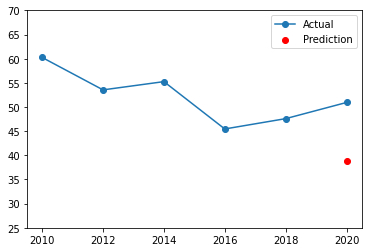

In [60]:
plt.plot(data_arima.idx.dt.year, data_arima.EPI, 'o-', label = "Actual")
plt.scatter(data_arima.idx.dt.year, data_arima.Prediction, label = "Prediction", color='red')
plt.legend()
plt.ylim([25, 70])
plt.show()

In [61]:
mt.mean_squared_error(data_test_arima.EPI, data_test_arima.Prediction)

147.52932490439358

#### Sample Country

In [62]:
data_train_arima = data[data['year'] < 2020][data['country'] == country].sort_values('year')
data_test_arima = data[data['year'].isin([2020])][data['country'] == country].sort_values('year')

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [63]:
data_train_arima = data_train_arima[['date', 'EPI']]
data_test_arima = data_test_arima[['date', 'EPI']]

data_train_arima.set_index('date', inplace=True)
data_test_arima.set_index('date', inplace=True)

data_train_arima.index = pd.to_datetime(data_train_arima.index)
data_test_arima.index = pd.to_datetime(data_test_arima.index)

In [64]:
data_train_arima

,EPI
date,
2010-01-01,81.13
2012-01-01,69.92
2014-01-01,78.04
2016-01-01,68.75
2018-01-01,70.10


In [65]:
data_test_arima

,EPI
date,
2020-01-01,77.7


In [66]:
stepwise_model = auto_arima(data_train_arima, 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            m=1,
                            seasonal=False,
                            d=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=False)
print(stepwise_model.aic())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.881, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27.418, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.197 seconds
27.417919922228585


In [67]:
stepwise_model.fit(data_train_arima)

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [68]:
future_forecast = stepwise_model.predict(n_periods=1)
data_test_arima['Prediction'] = future_forecast
data_arima = pd.concat([data_train_arima, data_test_arima])
data_arima['idx'] = data_arima.index #.astype(str)

In [69]:
data_arima[['EPI','Prediction']]

,EPI,Prediction
date,,
2010-01-01,81.13,NaN
2012-01-01,69.92,NaN
2014-01-01,78.04,NaN
2016-01-01,68.75,NaN
2018-01-01,70.10,NaN
2020-01-01,77.70,64.872379


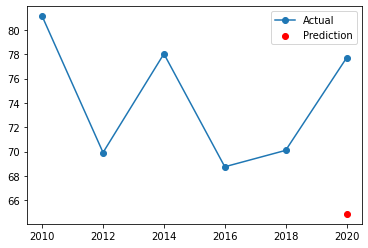

In [70]:
plt.plot(data_arima.idx.dt.year, data_arima.EPI, 'o-', label = "Actual")
plt.scatter(data_arima.idx.dt.year, data_arima.Prediction, label = "Prediction", color='red')
plt.legend()
plt.show()

#### Predict 2022

#### All Countries

In [71]:
data_train_arima = data_arima_all[data_arima_all['year'] < 2022].sort_values('year')
data_test_arima = data_arima_all[data_arima_all['year'].isin([2022])].sort_values('year')

In [72]:
data_train_arima = data_train_arima[['date', 'EPI']]
data_test_arima = data_test_arima[['date', 'EPI']]

data_train_arima.set_index('date', inplace=True)
data_test_arima.set_index('date', inplace=True)

data_train_arima.index = pd.to_datetime(data_train_arima.index)
data_test_arima.index = pd.to_datetime(data_test_arima.index)

stepwise_model = auto_arima(data_train_arima, 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            m=1,
                            seasonal=False,
                            d=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=False)
print(stepwise_model.aic())

stepwise_model.fit(data_train_arima)

future_forecast = stepwise_model.predict(n_periods=1)
data_test_arima['Prediction'] = future_forecast
data_arima = pd.concat([data_train_arima, data_test_arima])
data_arima['idx'] = data_arima.index #.astype(str)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.933, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34.852, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.868, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2438603.608, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39.553, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=38.514, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.921 seconds
34.8522281264441


In [73]:
data_arima[['EPI','Prediction']]

,EPI,Prediction
date,,
2010-01-01,60.251138,NaN
2012-01-01,53.542439,NaN
2014-01-01,55.251382,NaN
2016-01-01,45.454146,NaN
2018-01-01,47.590244,NaN
2020-01-01,50.937398,NaN
2022-01-01,44.358537,44.756014


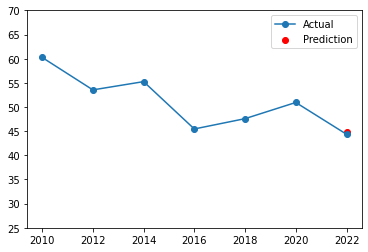

In [74]:
plt.plot(data_arima.idx, data_arima.EPI, 'o-', label = "Actual")
plt.scatter(data_arima.idx, data_arima.Prediction, label = "Prediction", color='red')
plt.legend()
plt.ylim([25, 70])
plt.show()

In [75]:
mt.mean_squared_error(data_test_arima.EPI, data_test_arima.Prediction)

0.15798856585889806

#### Sample Country

In [76]:
data_train_arima = data[data['year'] < 2022][data['country'] == country].sort_values('year')
data_test_arima = data[data['year'].isin([2022])][data['country'] == country].sort_values('year')

C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\ozlem.gunes\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [77]:
data_train_arima = data_train_arima[['date', 'EPI']]
data_test_arima = data_test_arima[['date', 'EPI']]

data_train_arima.set_index('date', inplace=True)
data_test_arima.set_index('date', inplace=True)

data_train_arima.index = pd.to_datetime(data_train_arima.index)
data_test_arima.index = pd.to_datetime(data_test_arima.index)

In [78]:
data_train_arima

,EPI
date,
2010-01-01,81.13
2012-01-01,69.92
2014-01-01,78.04
2016-01-01,68.75
2018-01-01,70.10
2020-01-01,77.70


In [79]:
data_test_arima

,EPI
date,
2022-01-01,59.3


In [80]:
stepwise_model = auto_arima(data_train_arima, 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            m=1,
                            seasonal=False,
                            d=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=False)
print(stepwise_model.aic())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.215, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.598, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=37.529, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1397421.593, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.877 seconds
37.528581428326504


In [81]:
stepwise_model.fit(data_train_arima)

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [82]:
future_forecast = stepwise_model.predict(n_periods=1)
data_test_arima['Prediction'] = future_forecast
data_arima = pd.concat([data_train_arima, data_test_arima])
data_arima['idx'] = data_arima.index #.astype(str)

In [83]:
data_arima[['EPI','Prediction']]

,EPI,Prediction
date,,
2010-01-01,81.13,NaN
2012-01-01,69.92,NaN
2014-01-01,78.04,NaN
2016-01-01,68.75,NaN
2018-01-01,70.10,NaN
2020-01-01,77.70,NaN
2022-01-01,59.30,61.724263


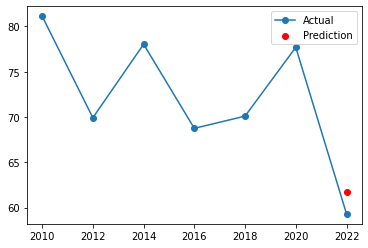

In [84]:
plt.plot(data_arima.idx, data_arima.EPI, 'o-', label = "Actual")
plt.scatter(data_arima.idx, data_arima.Prediction, label = "Prediction", color='red')
plt.legend()
plt.show()